Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Unzip the Dataset

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/LLM assignment 2/IMDB Dataset.csv.zip"
extract_path = "/content/drive/MyDrive/LLM assignment 2"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Install Required Libraries

In [ ]:
!pip install transformers datasets scikit-learn pandas matplotlib tqdm


Import All Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset
import matplotlib.pyplot as plt


Load and Prepare the IMDb Dataset



In [ ]:
# Load CSV
df = pd.read_csv("/content/drive/MyDrive/LLM assignment 2/IMDB Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


/tmp/ipython-input-6-995433922.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(x='sentiment', data=df, palette=colors)


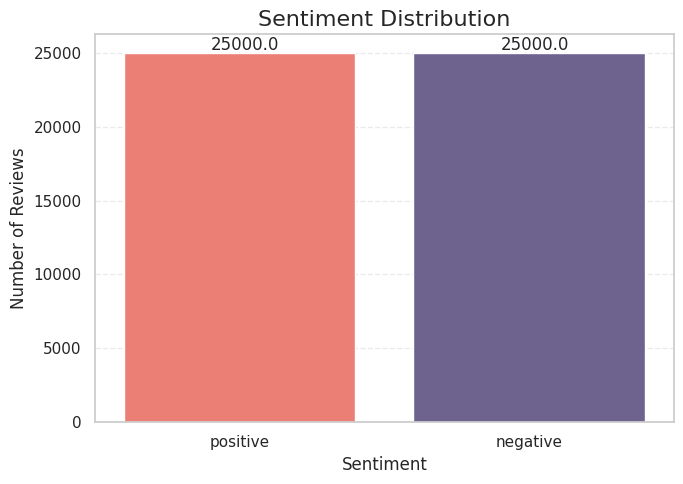

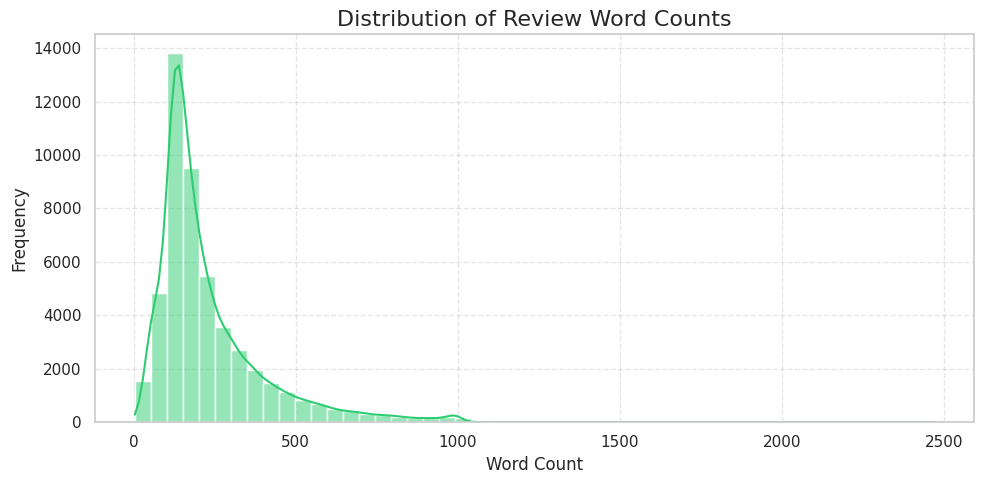

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set clean style
sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/LLM assignment 2/IMDB Dataset.csv")

# Add word count column
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

# Define color palette
colors = {'positive': '#FF6F61', 'negative': '#6B5B95'}

# 1. Sentiment distribution countplot
plt.figure(figsize=(7, 5))
ax1 = sns.countplot(x='sentiment', data=df, palette=colors)
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
for p in ax1.patches:
    ax1.annotate(f"{p.get_height()}", (p.get_x() + 0.3, p.get_height() + 200))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 2. Histogram of word count
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=50, kde=True, color='#2ECC71')
plt.title("Distribution of Review Word Counts", fontsize=16)
plt.xlabel("Word Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Preprocessing

In [ ]:
# Map sentiment labels to integers
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Train/test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)


 7.Tokenization with BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=256)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Create Dataset Objects for Hugging Face Trainer

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)


Load BERT Model for Fine-Tuning

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Configuration

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to=[]

)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()




/tmp/ipython-input-11-971759315.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.292900,0.281303,0.910300,0.908497
2,0.183600,0.312817,0.923200,0.924260
3,0.001300,0.387288,0.926300,0.927282


TrainOutput(global_step=15000, training_loss=0.2122190417287871, metrics={'train_runtime': 13381.6906, 'train_samples_per_second': 8.967, 'train_steps_per_second': 1.121, 'total_flos': 1.57866633216e+16, 'train_loss': 0.2122190417287871, 'epoch': 3.0})

Evaluate the Model on test Set





In [ ]:


val_texts, test_texts, val_labels, test_labels = train_test_split(
    val_texts, val_labels, test_size=0.5, random_state=42
)

# Tokenize test data
test_encodings = tokenize_function(test_texts)

# Create test dataset object
test_dataset = IMDbDataset(test_encodings, test_labels)


In [ ]:
train_eval = trainer.predict(train_dataset)
train_preds = np.argmax(train_eval.predictions, axis=1)
train_labels_array = train_eval.label_ids

from sklearn.metrics import classification_report

print("Train Set Classification Report:\n")
print(classification_report(train_labels_array, train_preds, target_names=['Negative', 'Positive']))


Train Set Classification Report:

              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99     20039
    Positive       0.99      0.99      0.99     19961

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



prediction

In [ ]:
test_predictions_output = trainer.predict(test_dataset)
test_preds = np.argmax(test_predictions_output.predictions, axis=1)
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_preds, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      1240
    Positive       0.92      0.94      0.93      1260

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



result- confusion matrix

<Figure size 600x600 with 0 Axes>

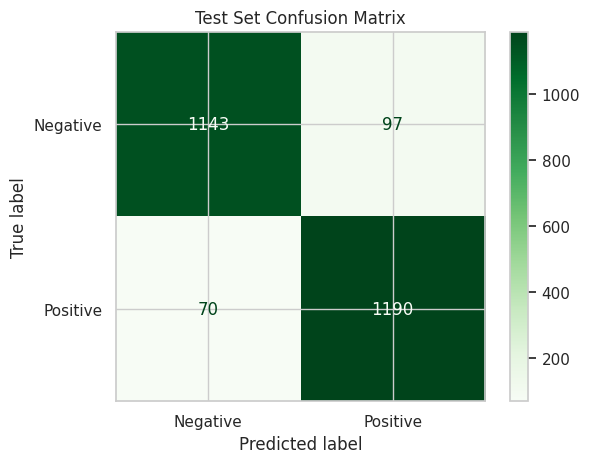

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_test = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive'])

plt.figure(figsize=(6,6))
disp.plot(cmap='Greens')
plt.title("Test Set Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model.pth')
